In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.dates import drange
import matplotlib.dates as mdates
import os

# Configs

In [2]:
class cfg:
    local = False

    remove_outliers = True
    # num_splits = 1

    num_month_splits = 5

In [3]:
file_paths_save = {
}

if cfg.local:
    save_dir = '../../data/split_data'
else:
    save_dir = '/kaggle/working'
    
for i in range(cfg.num_month_splits):
    file_paths_save[f'train_split_{i}'] = f'{save_dir}/train/train_{i}.parquet'
    file_paths_save[f'val_split_{i}'] = f'{save_dir}/val/val_{i}.parquet'

file_paths_save[f'test_split_0'] = f'{save_dir}/test/test_0.parquet'

display(file_paths_save)

{'train_split_0': '/kaggle/working/train/train_0.parquet',
 'val_split_0': '/kaggle/working/val/val_0.parquet',
 'train_split_1': '/kaggle/working/train/train_1.parquet',
 'val_split_1': '/kaggle/working/val/val_1.parquet',
 'train_split_2': '/kaggle/working/train/train_2.parquet',
 'val_split_2': '/kaggle/working/val/val_2.parquet',
 'train_split_3': '/kaggle/working/train/train_3.parquet',
 'val_split_3': '/kaggle/working/val/val_3.parquet',
 'train_split_4': '/kaggle/working/train/train_4.parquet',
 'val_split_4': '/kaggle/working/val/val_4.parquet',
 'test_split_0': '/kaggle/working/test/test_0.parquet'}

In [4]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

In [5]:
create_dir('/kaggle/working/train')
create_dir('/kaggle/working/val')
create_dir('/kaggle/working/test')

In [6]:
if cfg.local:
    data_dir = '../../data/original_data_updated'
else:
    data_dir = '/kaggle/input/godaddy-microbusiness-density-forecasting'

file_paths = {
    'train': f'{data_dir}/train.csv',
    'revealed_test': f'{data_dir}/revealed_test.csv',
    'test': f'{data_dir}/test.csv',
    'census_starter': f'{data_dir}/census_starter.csv',
    'sample_submission': f'{data_dir}/sample_submission.csv',
}

# Helpers

In [8]:
def preview_df(df, num=1):
    print(f'{len(df):,}')
    display(df.head(num))

# Load train and test

In [9]:
train_df = pd.read_csv(file_paths['train'])
train_df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


In [10]:
revealed_test_df = pd.read_csv(file_paths['revealed_test'])
revealed_test_df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145
3,1003_2022-12-01,1003,Baldwin County,Alabama,2022-12-01,8.250630,14133
4,1005_2022-11-01,1005,Barbour County,Alabama,2022-11-01,1.247223,247
...,...,...,...,...,...,...,...
6265,56041_2022-12-01,56041,Uinta County,Wyoming,2022-12-01,4.050703,588
6266,56043_2022-11-01,56043,Washakie County,Wyoming,2022-11-01,3.143093,190
6267,56043_2022-12-01,56043,Washakie County,Wyoming,2022-12-01,3.060380,185
6268,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100


In [11]:
train_df = pd.concat([train_df, revealed_test_df], axis=0)
train_df = train_df.reset_index(drop=True)
train_df = train_df.sort_values(['cfips', 'first_day_of_month'], ascending=[True, True])

In [12]:
test_df = pd.read_csv(file_paths['test'])
test_df.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


# Dtypes change

* train

In [14]:
train_df.dtypes

row_id                    object
cfips                      int64
county                    object
state                     object
first_day_of_month        object
microbusiness_density    float64
active                     int64
dtype: object

In [15]:
for col in ['cfips', 'active']:
    train_df[col] = pd.to_numeric(train_df[col], downcast='signed')

In [16]:
train_df.county = train_df.county.astype('string')
train_df.state = train_df.state.astype('string')
train_df.row_id = train_df.row_id.astype('string')

In [17]:
train_df.first_day_of_month = train_df.first_day_of_month.apply(lambda x: datetime.date.fromisoformat(x))

In [18]:
train_df = train_df.sort_values(['cfips', 'first_day_of_month'], ascending=[True, True])
train_df = train_df.reset_index(drop=True)

In [19]:
train_df.dtypes

row_id                    string
cfips                      int32
county                    string
state                     string
first_day_of_month        object
microbusiness_density    float64
active                     int32
dtype: object

* test

In [20]:
test_df.row_id = test_df.row_id.astype('string')
test_df['cfips'] = pd.to_numeric(test_df['cfips'], downcast='signed')
test_df.first_day_of_month = test_df.first_day_of_month.apply(lambda x: datetime.date.fromisoformat(x))
test_df.dtypes

row_id                string
cfips                  int32
first_day_of_month    object
dtype: object

In [21]:
test_df = test_df.sort_values(['cfips', 'first_day_of_month'], ascending=[True, True])
test_df = test_df.reset_index(drop=True)

# Separate state and county codes

In [22]:
def add_state_code(df):
    df['state_code'] = df.cfips.apply(
        lambda x: int(str(x)[:2]) if x >= 10_000 else int(str(x)[:1])
    )

    if df.state_code.max() <= 255:
        df.state_code = df.state_code.astype('uint8')
    else:
        df.state_code = df.state_code.astype('int16')

    return df
def add_county_code(df):
    df['county_code'] = df.cfips.apply(
        lambda x: int(str(x)[-3:])
    )

    if df.county_code.max() <= 255:
        df.county_code = df.county_code.astype('uint8')
    else:
        df.county_code = df.county_code.astype('int16')

    return df

In [23]:
# train_df = add_county_code(train_df)
# train_df = add_state_code(train_df)
# train_df.head()

In [24]:
# test_df = add_county_code(test_df)
# test_df = add_state_code(test_df)
# test_df.head()

# Detect outliers/irregularities

In [25]:
tmp = train_df.loc[train_df.cfips==46127].sort_values('first_day_of_month')
tmp.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
99220,46127_2019-08-01,46127,Union County,South Dakota,2019-08-01,277.535980,31245
99221,46127_2019-09-01,46127,Union County,South Dakota,2019-09-01,5.880263,662
99222,46127_2019-10-01,46127,Union County,South Dakota,2019-10-01,284.340030,32011
99223,46127_2019-11-01,46127,Union County,South Dakota,2019-11-01,5.871380,661
99224,46127_2019-12-01,46127,Union County,South Dakota,2019-12-01,5.862498,660


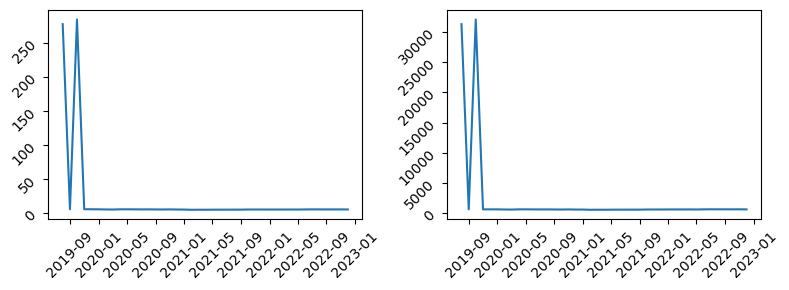

In [26]:
fig,ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(tmp.first_day_of_month, tmp.microbusiness_density)
ax[1].plot(tmp.first_day_of_month, tmp.active)
ax[0].tick_params(rotation=45)
ax[1].tick_params(rotation=45)
plt.tight_layout()

### Outliers based on delta (spikes)

In [28]:
def detect_sudden_change(df, target_col):
    cfips_with_outliers = []
    for uniq_cfips in df.cfips.unique():
        tmp1 = df.loc[df.cfips == uniq_cfips].copy()
        tmp1['one_month_change'] = tmp1[target_col].shift(1).fillna(tmp1[target_col].median())
        diff = tmp1[target_col].median() * 2
        tmp1['one_month_change'] = (tmp1['one_month_change'] - tmp1[target_col] > diff) | (tmp1['one_month_change'] - tmp1[target_col] < -diff)
        if tmp1.one_month_change.any():
            cfips_with_outliers.append(uniq_cfips)
            # break

        del tmp1['one_month_change']

    print('Num counties with outliers -', len(cfips_with_outliers))

    return cfips_with_outliers

In [29]:
train_df

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
128530,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
128531,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100
128532,56045_2022-10-01,56045,Weston County,Wyoming,2022-10-01,1.785395,100
128533,56045_2022-11-01,56045,Weston County,Wyoming,2022-11-01,1.785395,100


In [30]:
# tmp = tmp.loc[tmp.first_day_of_month > datetime.date(2021,1,1)]
cfips_with_outliers = detect_sudden_change(train_df, 'active')

Num counties with outliers - 24


In [31]:
print(cfips_with_outliers)

[5055, 5141, 12001, 12045, 13025, 13211, 16077, 17075, 18025, 19143, 19177, 21211, 28055, 29063, 29171, 31009, 32510, 38033, 38039, 41023, 46127, 48063, 48205, 55067]


In [32]:
def plot_cfips(cfips_list, target_col='active'):
    num_cols = 4
    num_rows = int(np.ceil(len(cfips_list) / num_cols))
    print(num_rows,num_cols)
    figure, axis = plt.subplots(num_rows, num_cols, figsize=(20,num_rows*4), squeeze=True)
    for i, problematic_cfips in enumerate(cfips_list):
        tmp = train_df.loc[train_df.cfips == problematic_cfips]

        ax = axis[i//num_cols,i%num_cols]
        ax.plot(tmp.first_day_of_month, tmp.active)
        ax.set_title(problematic_cfips)
        ax.tick_params(rotation=45)

    print('Num counties -', len(cfips_list))
    plt.tight_layout()
    plt.show()

6 4
Num counties - 24


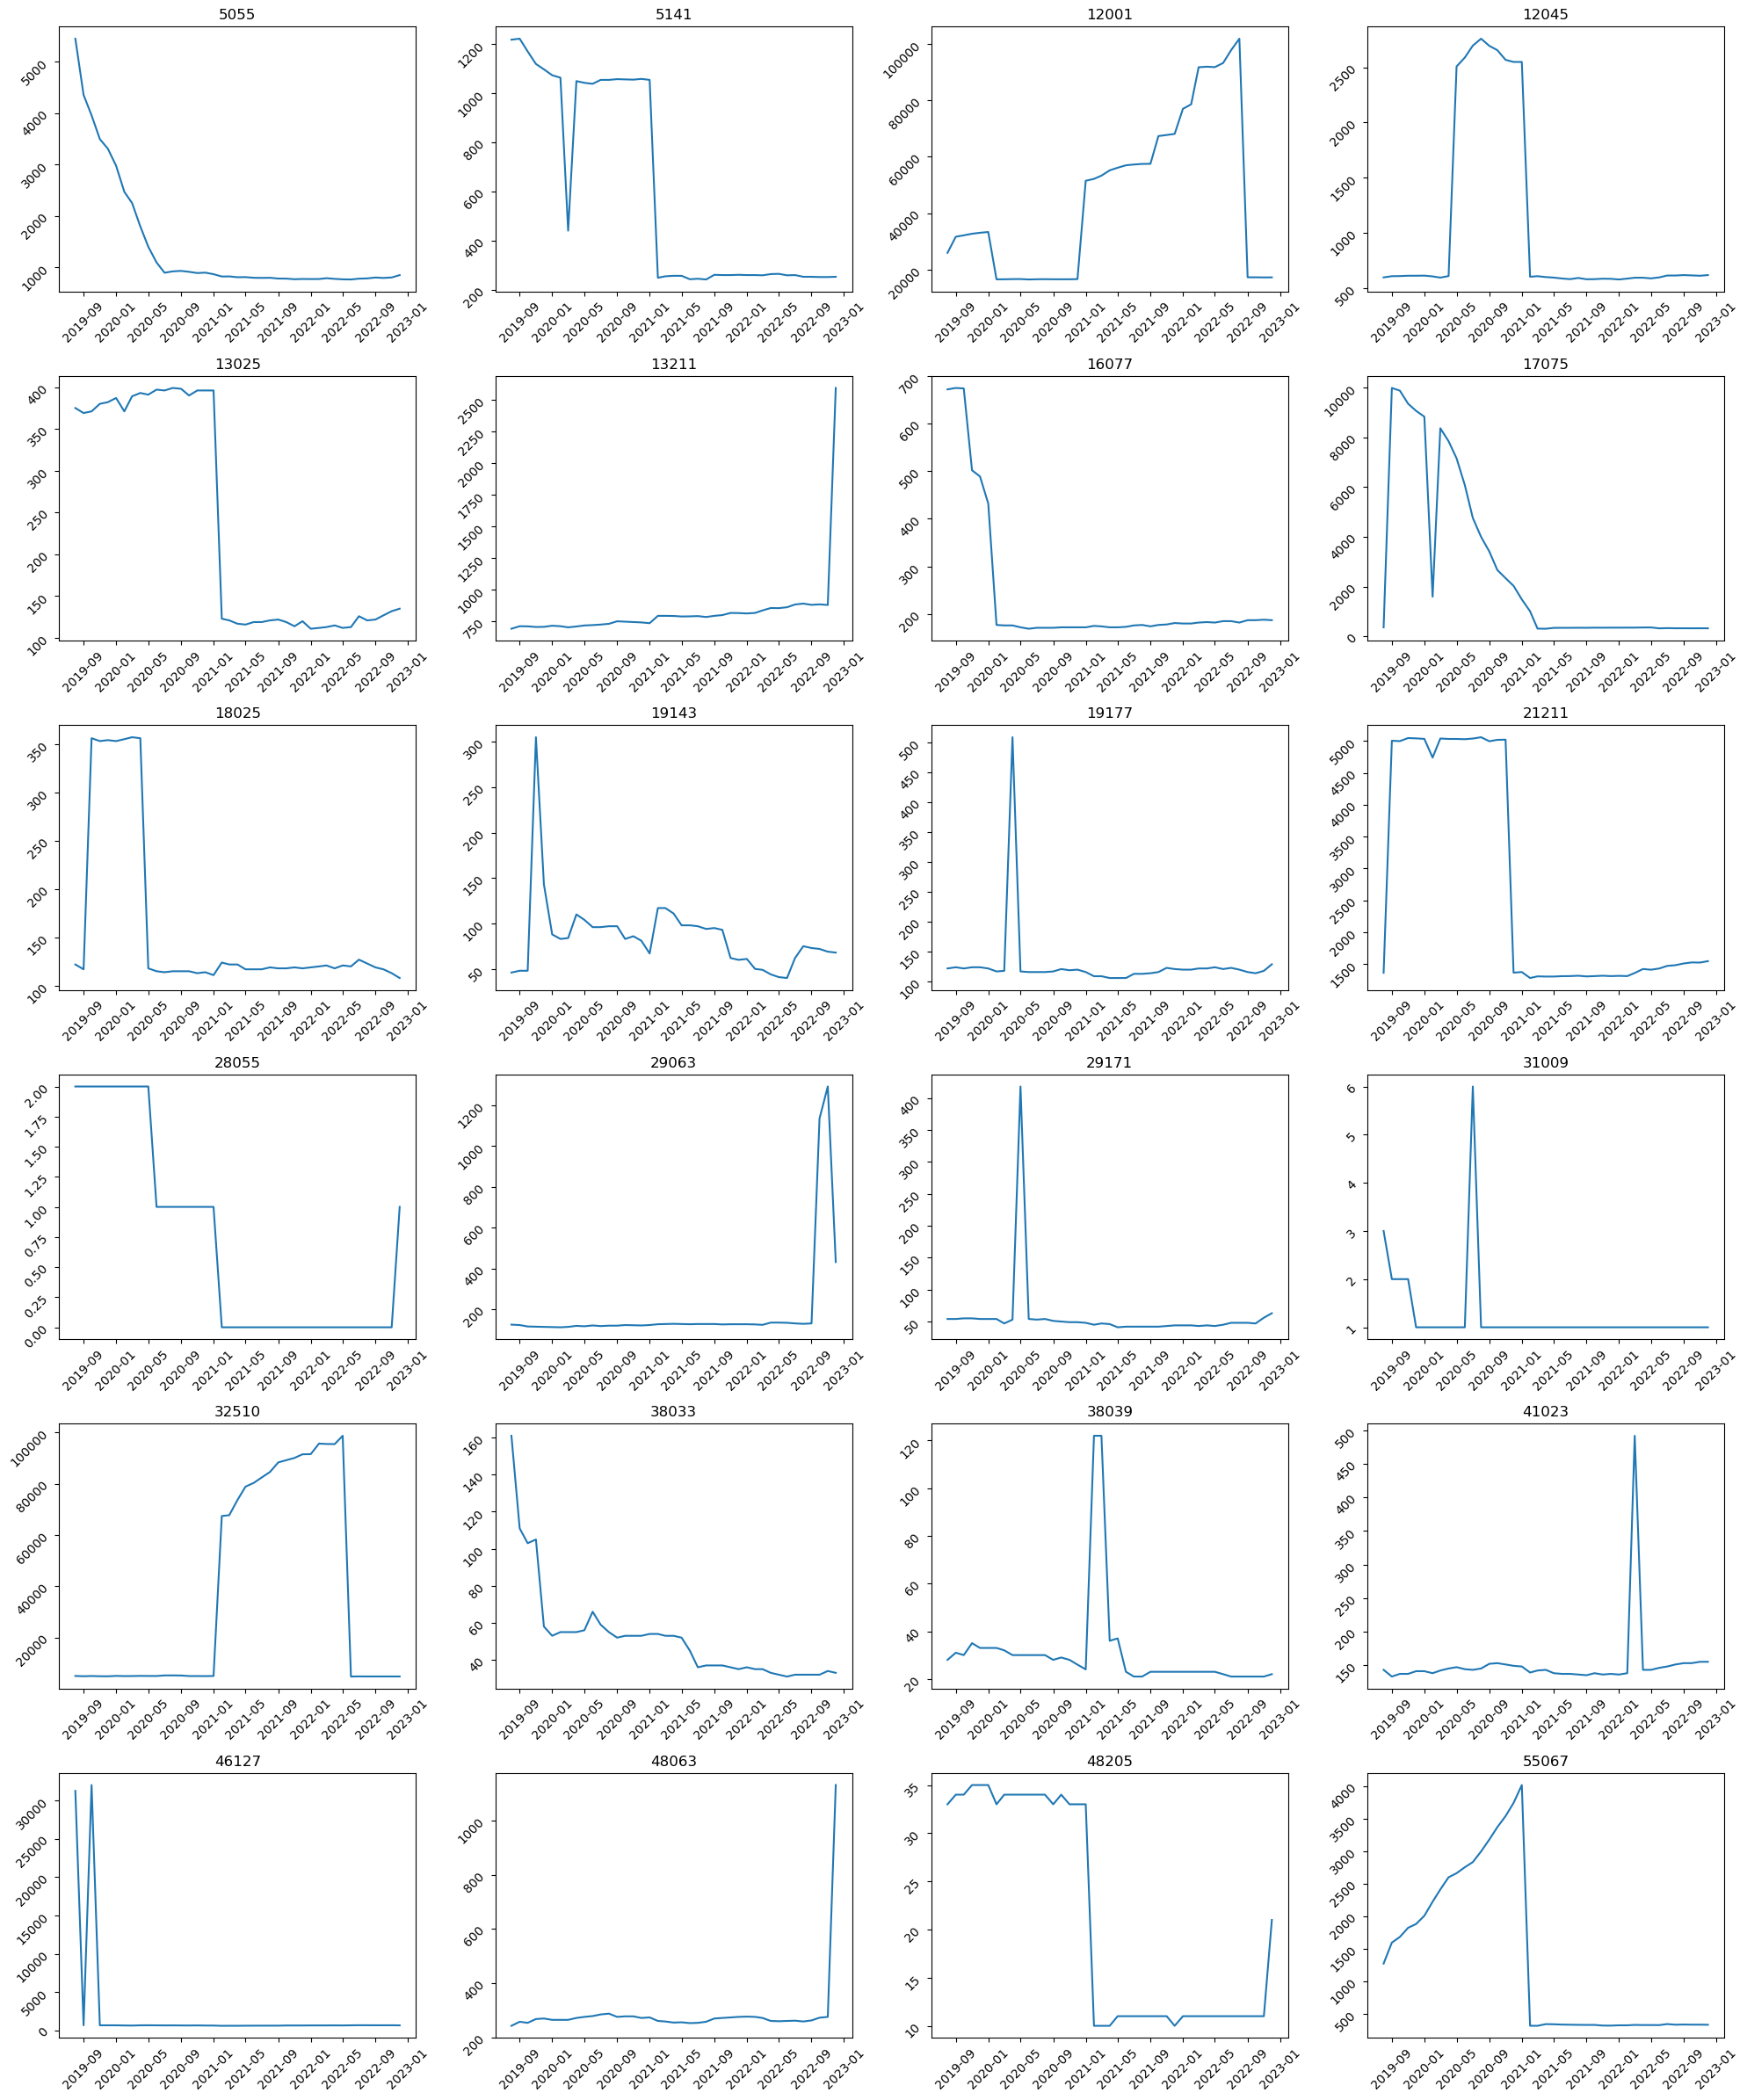

In [33]:
plot_cfips(cfips_with_outliers)

In [34]:
# Not all are changed, some are left because they are plausible

# 29063 -> Leave as is
# 32510 -> Completely flatten the change

# 48063 -> Camp County 9k population, leave as is
# 13211 -> Rise from 800 to 2500, leave as is

In [35]:
# population_sizes = pd.read_parquet('../../data/other_data/population_sizes.parquet')
# population_sizes.loc[population_sizes.cfips == 32510]

# census_data_df = pd.read_csv(file_paths['census_starter'])
# census_data_df.loc[census_data_df.cfips==32510]

3 4
Num counties - 10


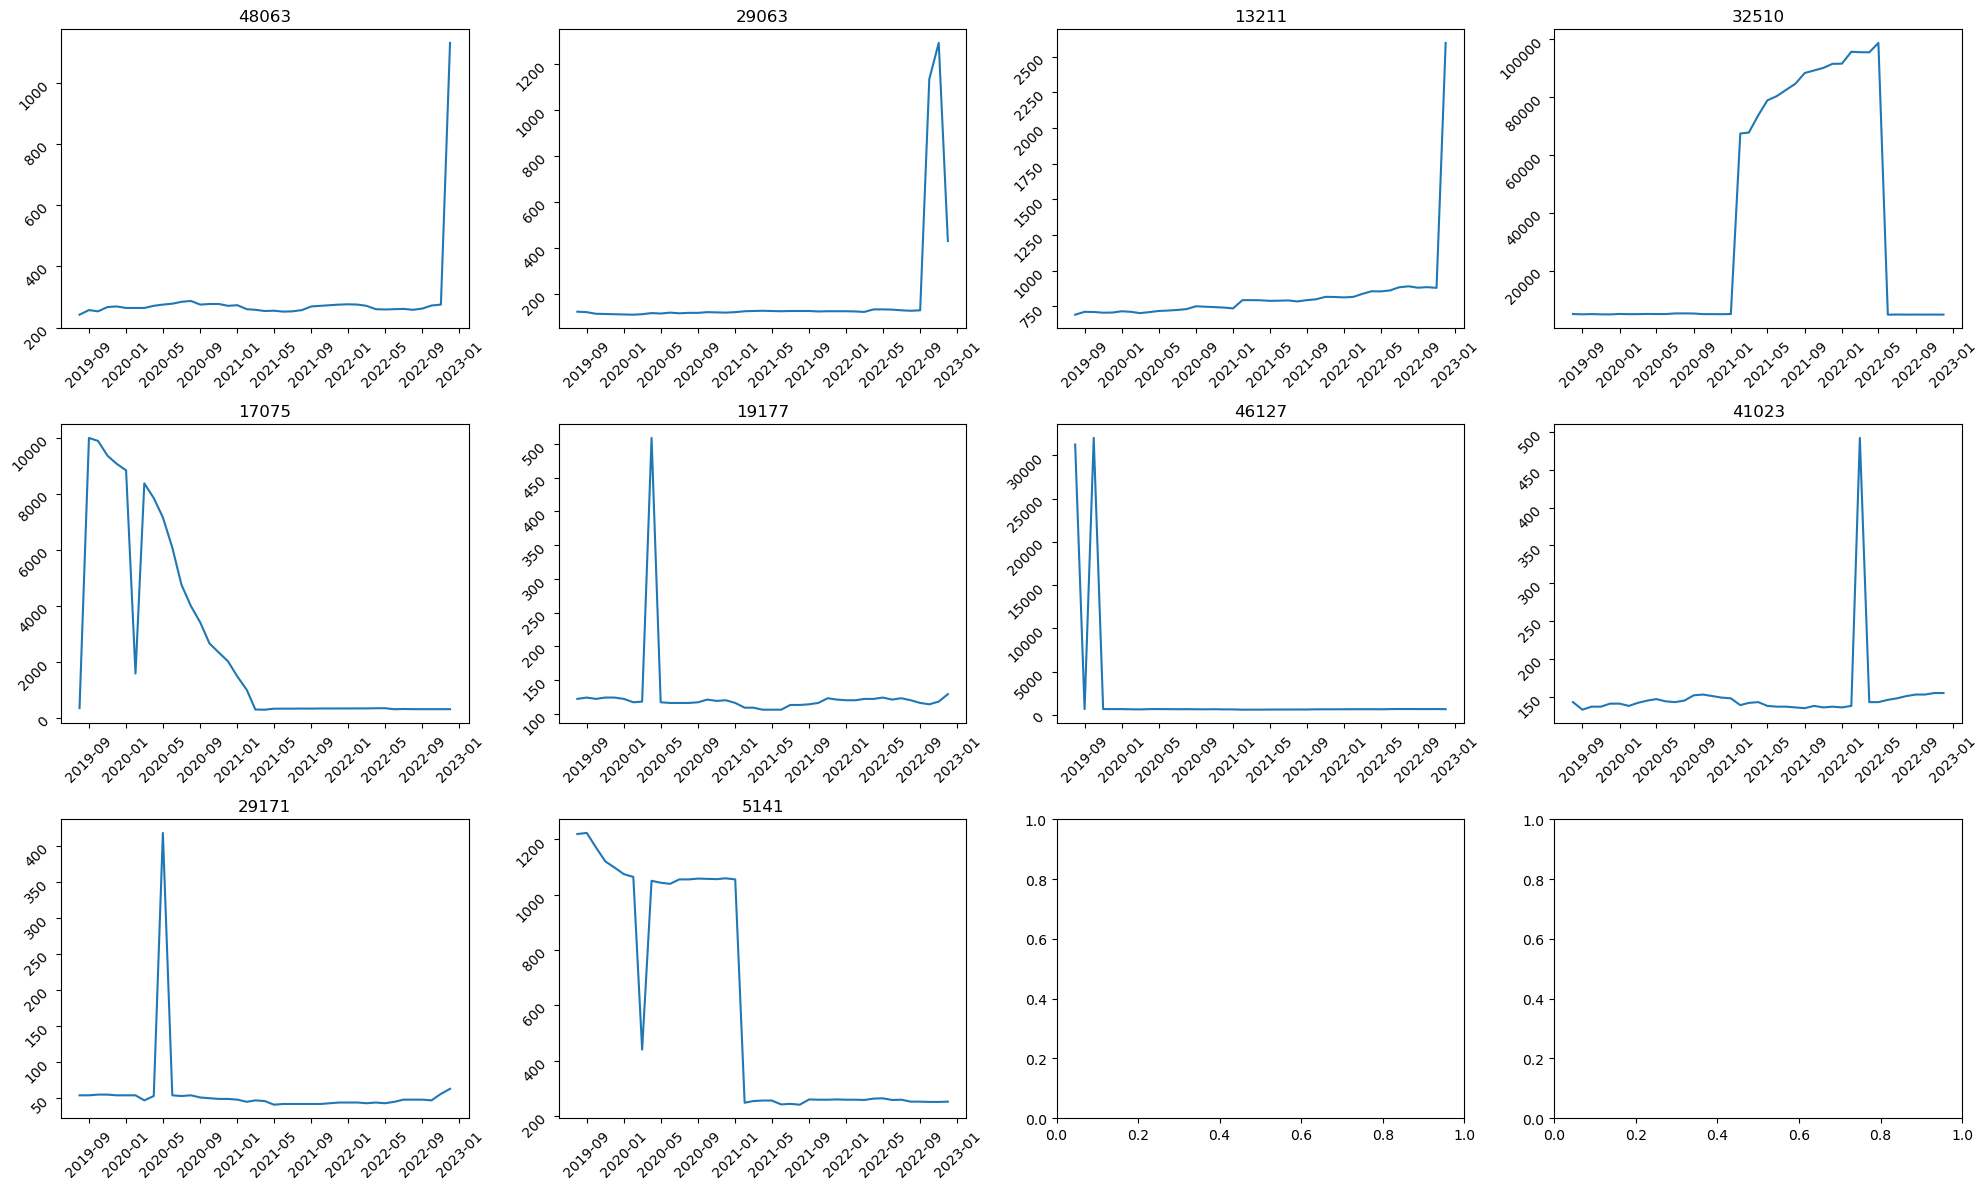

In [36]:
cfips_with_outliers = [48063, 29063, 13211, 32510, 17075, 19177, 46127, 41023, 29171, 5141]
plot_cfips(cfips_with_outliers)

2 4
Num counties - 7


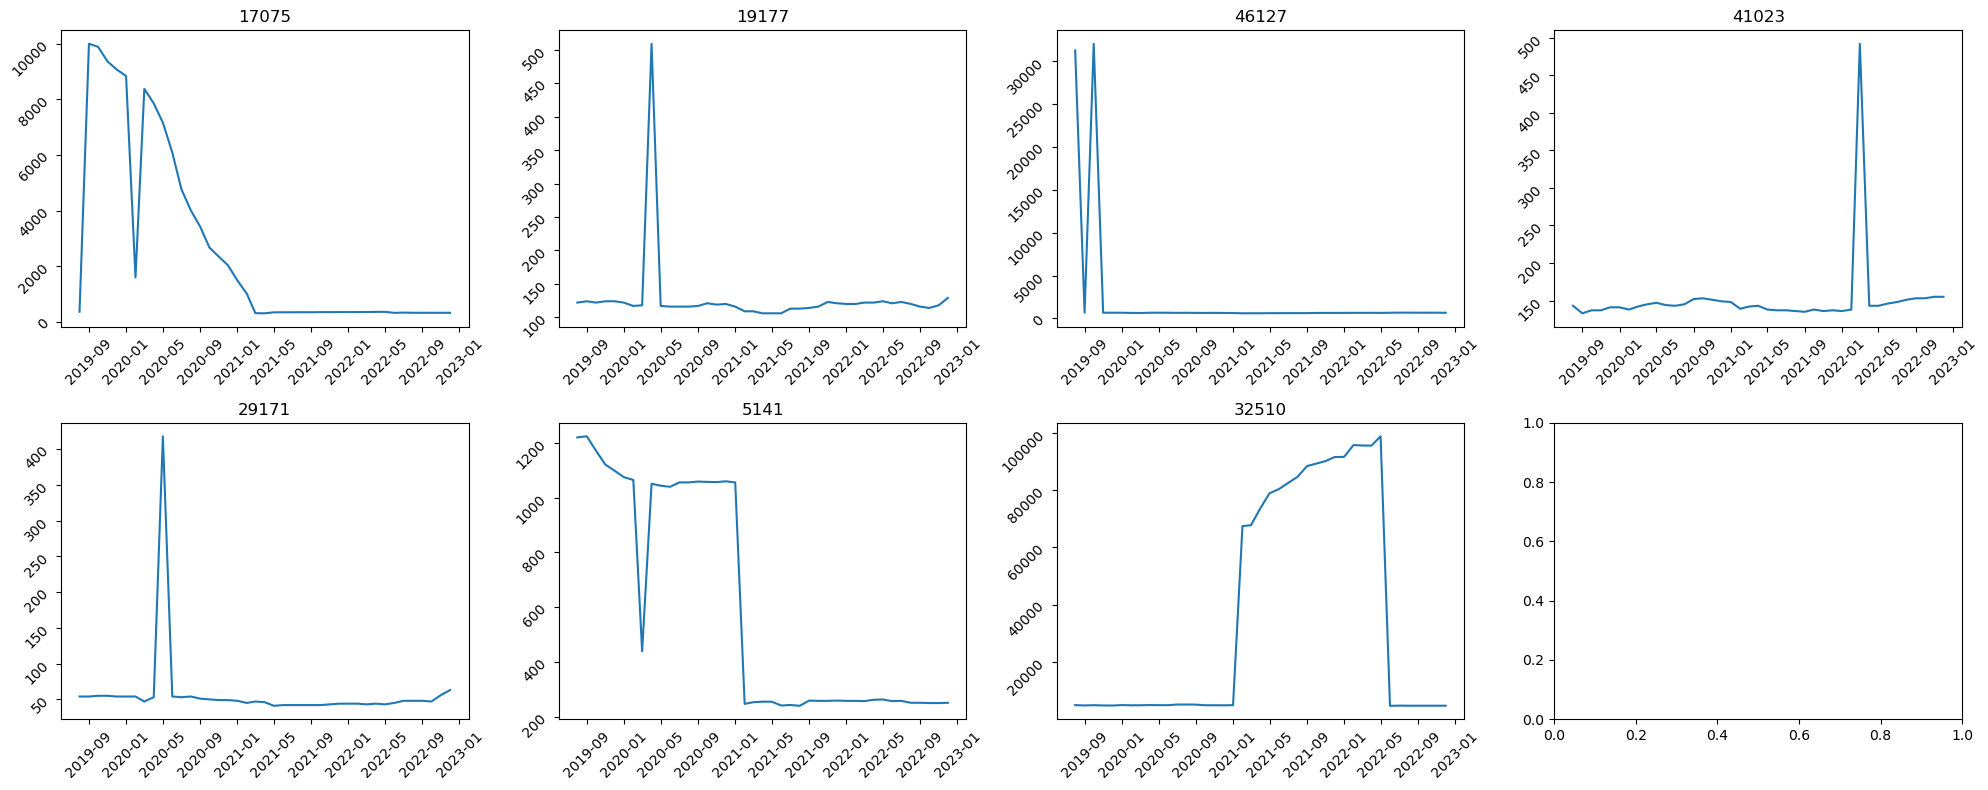

In [37]:
cfips_to_cahnge = [17075, 19177, 46127, 41023, 29171, 5141, 32510]
plot_cfips(cfips_to_cahnge)

* Remove ouliers

In [ ]:
# It is easest to do it manually

In [38]:
if cfg.remove_outliers:
    train_df.loc[(train_df.cfips==17075) & (train_df.first_day_of_month == datetime.date(2019,8,1)), 'microbusiness_density'] = 45.064705
    train_df.loc[(train_df.cfips==17075) & (train_df.first_day_of_month == datetime.date(2020,2,1)), 'microbusiness_density'] = 39.0
    train_df.loc[(train_df.cfips==19177) & (train_df.first_day_of_month == datetime.date(2020,4,1)), 'microbusiness_density'] = 2.14
    train_df.loc[(train_df.cfips==46127) & (train_df.first_day_of_month == datetime.date(2019,8,1)), 'microbusiness_density'] = 5.880263
    train_df.loc[(train_df.cfips==46127) & (train_df.first_day_of_month == datetime.date(2019,10,1)), 'microbusiness_density'] = 5.871380
    train_df.loc[(train_df.row_id=='41023_2022-03-01'), 'microbusiness_density'] = 2.4
    train_df.loc[(train_df.row_id=='29171_2020-05-01'), 'microbusiness_density'] = 1.43
    train_df.loc[(train_df.row_id=='5141_2020-03-01'), 'microbusiness_density'] = 7.9
    train_df.loc[(train_df.cfips==32510) & (train_df.active>10_000), 'microbusiness_density'] = 11


    train_df.loc[(train_df.cfips==17075) & (train_df.first_day_of_month == datetime.date(2019,8,1)), 'active'] = 9994
    train_df.loc[(train_df.cfips==17075) & (train_df.first_day_of_month == datetime.date(2020,2,1)), 'active'] = 8700
    train_df.loc[(train_df.cfips==19177) & (train_df.first_day_of_month == datetime.date(2020,4,1)), 'active'] = 118
    train_df.loc[(train_df.cfips==46127) & (train_df.first_day_of_month == datetime.date(2019,8,1)), 'active'] = 662
    train_df.loc[(train_df.cfips==46127) & (train_df.first_day_of_month == datetime.date(2019,10,1)), 'active'] = 661
    train_df.loc[(train_df.row_id=='41023_2022-03-01'), 'active'] = 140
    train_df.loc[(train_df.row_id=='29171_2020-05-01'), 'active'] = 53
    train_df.loc[(train_df.row_id=='5141_2020-03-01'), 'active'] = 1055
    train_df.loc[(train_df.cfips==32510) & (train_df.active>10_000), 'active'] = 4800

2 4
Num counties - 7


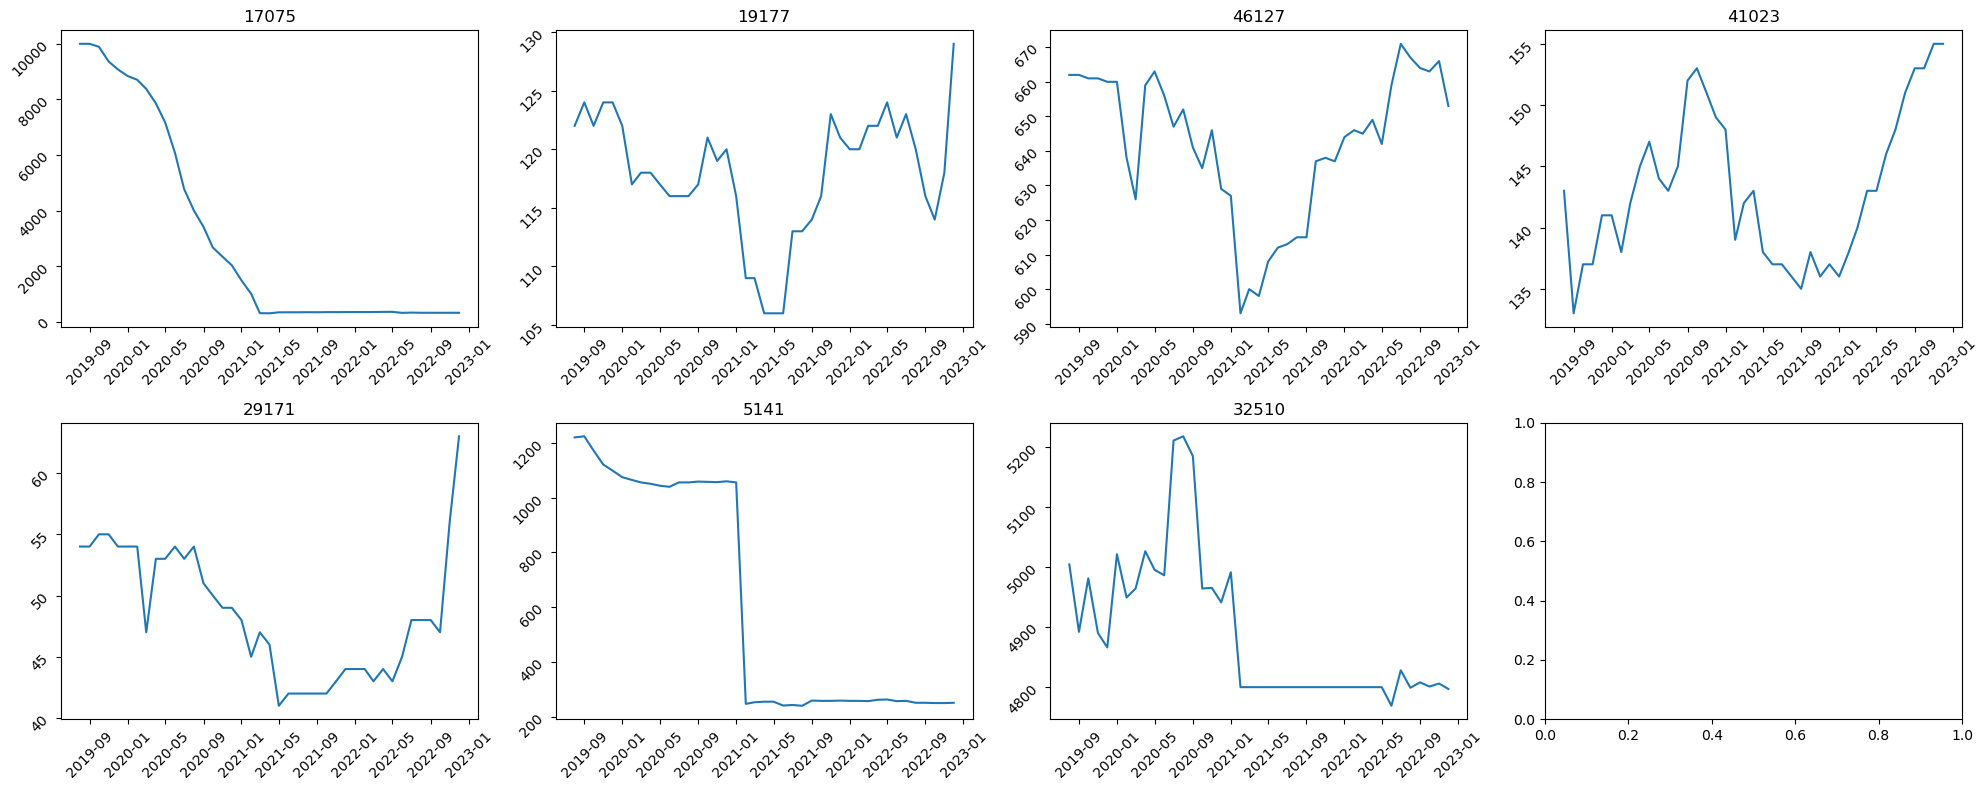

In [39]:
cfips_to_cahnge = [17075, 19177, 46127, 41023, 29171, 5141, 32510]
plot_cfips(cfips_to_cahnge)

### Population outliers

In [40]:
train_df['population_size'] = train_df['active'] / train_df['microbusiness_density']
train_df.population_size = train_df.population_size.fillna(0)
train_df.population_size = train_df.population_size.astype('int32')

population_outliers = detect_sudden_change(train_df, 'population_size')

Num counties with outliers - 2


In [41]:
for po in population_outliers:
    county = train_df.loc[train_df.cfips == po].county.values[0]
    state = train_df.loc[train_df.cfips == po].state.values[0]
    print(po, county, state)

15005 Kalawao County Hawaii
28055 Issaquena County Mississippi


In [ ]:
# They are low population counties

In [42]:
del train_df['population_size']

### It looks like there are more outliers but they are plausible

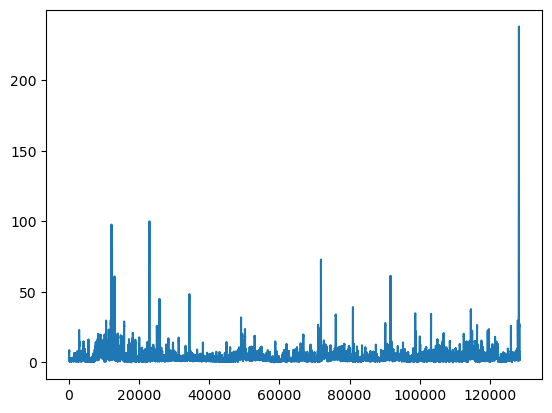

In [44]:
plt.plot(train_df.microbusiness_density)

In [45]:
train_df.loc[train_df.microbusiness_density>100]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
128276,56033_2021-12-01,56033,Sheridan County,Wyoming,2021-12-01,100.16453,23743
128278,56033_2022-02-01,56033,Sheridan County,Wyoming,2022-02-01,102.14349,24446
128279,56033_2022-03-01,56033,Sheridan County,Wyoming,2022-03-01,104.88029,25101
128280,56033_2022-04-01,56033,Sheridan County,Wyoming,2022-04-01,105.97919,25364
128281,56033_2022-05-01,56033,Sheridan County,Wyoming,2022-05-01,106.20900,25419
128282,56033_2022-06-01,56033,Sheridan County,Wyoming,2022-06-01,113.19935,27092
128283,56033_2022-07-01,56033,Sheridan County,Wyoming,2022-07-01,114.09351,27306
128284,56033_2022-08-01,56033,Sheridan County,Wyoming,2022-08-01,113.44169,27150
128285,56033_2022-09-01,56033,Sheridan County,Wyoming,2022-09-01,128.26224,30697
128286,56033_2022-10-01,56033,Sheridan County,Wyoming,2022-10-01,227.75665,54509


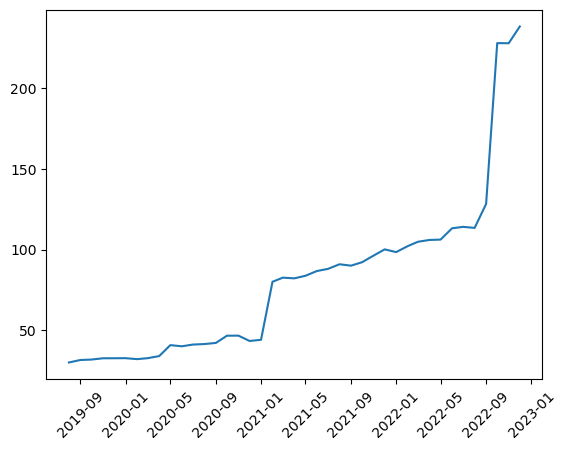

In [46]:
tmp = train_df.loc[train_df.cfips==56033]
plt.plot(tmp.first_day_of_month, tmp.microbusiness_density)
plt.xticks(rotation=45)
plt.show()

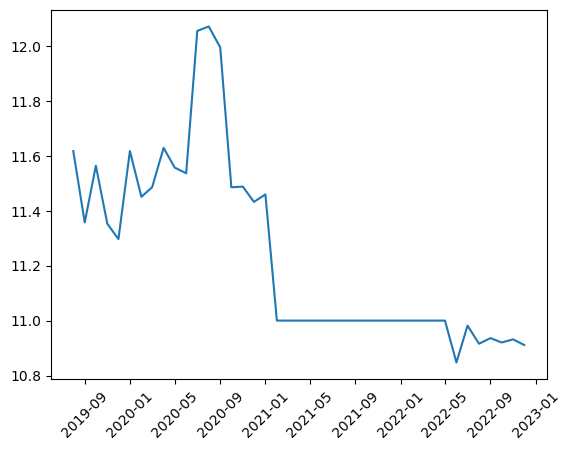

In [47]:
tmp = train_df.loc[train_df.cfips==32510]
plt.plot(tmp.first_day_of_month, tmp.microbusiness_density)
plt.xticks(rotation=45)
plt.show()

### Inter quantile range difference

In [48]:
def calc_iqr_dist(df, col='microbusiness_density'):
    q1 = tmp[col].quantile(0.25)
    q3 = tmp[col].quantile(0.75)
    return np.abs(q3-q1)

In [49]:
cfips_with_outliers = []
for uniq_cfips in train_df.cfips.unique():

    tmp = train_df.loc[train_df.cfips == uniq_cfips]
    iqr = calc_iqr_dist(tmp)

    if len(tmp.loc[tmp.microbusiness_density / iqr < 1.5]) > 0:
        cfips_with_outliers.append(uniq_cfips)
        
print('Num counties with outliers -', len(cfips_with_outliers))

Num counties with outliers - 96


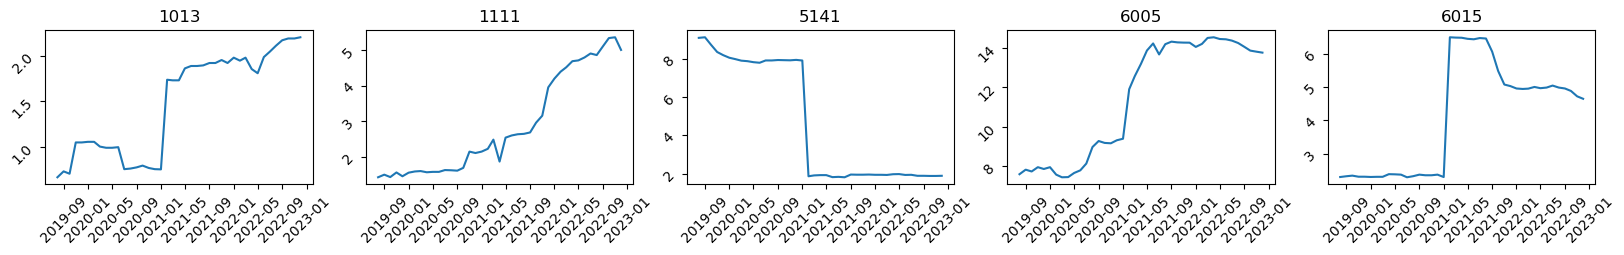

In [50]:
figure, axis = plt.subplots(1, len(cfips_with_outliers[0:5]), figsize=(20,2), squeeze=True)
for i,pc in enumerate(cfips_with_outliers[0:5]):
    tmp = train_df.loc[train_df.cfips == pc]
    ax = axis[i]
    ax.plot(tmp.first_day_of_month, tmp.microbusiness_density)
    ax.tick_params(rotation=45)
    ax.set_title(pc)
plt.show()

# Split

In [53]:
def subtract_month(from_date, sub_amount=1):
    assert sub_amount <= 12

    new_year = from_date.year
    new_month = from_date.month

    new_month = new_month - sub_amount
    if new_month <= 0:
        new_month = 12 + new_month
        new_year = new_year - 1

    return datetime.date(new_year, new_month, from_date.day)

def add_month(from_date, add_amount=1):
    assert add_amount <= 12

    new_year = from_date.year
    new_month = from_date.month

    new_month = new_month + add_amount
    if new_month > 12:
        new_month = new_month - 12
        new_year = new_year + 1

    return datetime.date(new_year, new_month, from_date.day)

# # Test:
# last_date = datetime.date(2023,3,1) # not including march
# first_date = datetime.date(2019,8,1) # not including march
# for i in range(0,6):
#     # print(subtract_month(last_date, i))
#     print(add_month(first_date, i))

In [54]:
test_df.first_day_of_month.min(), test_df.first_day_of_month.max()

(datetime.date(2022, 11, 1), datetime.date(2023, 6, 1))

In [55]:
train_df.first_day_of_month.min(), train_df.first_day_of_month.max()

(datetime.date(2019, 8, 1), datetime.date(2022, 12, 1))

In [56]:
train_df.first_day_of_month.min()

datetime.date(2019, 8, 1)

In [57]:
# I chose to have different lengths of sets here
# That is split 0 have 4 months more than split 4 (both train and val)
# But they will be removed in data preparation

In [58]:
# Determine split dates
# By month

num_splits = cfg.num_month_splits

first_train_d = train_df.first_day_of_month.min()
last_train_d = subtract_month(train_df.first_day_of_month.max(), 5)
train_from = []
train_to = []
for i in range(num_splits):
    train_from.append(first_train_d)
    train_to.append(subtract_month(last_train_d,i))

first_val_d = add_month(first_train_d, 5)
last_val_d = train_df.first_day_of_month.max()
val_from = []
val_to = []
for i in range(num_splits):
    val_from.append(first_val_d)
    val_to.append(subtract_month(last_val_d,i))

In [59]:
last_test_d = datetime.date(2023, 5, 1)
first_test_target_d = datetime.date(2023, 1, 1)
test_target_from = [first_test_target_d]
test_target_to = [last_test_d]
test_from = [add_month(val_from[0], 5)]
test_to = [last_test_d]

In [60]:
print([d.isoformat() for d in train_from])
print([d.isoformat() for d in train_to])
print([d.isoformat() for d in val_from])
print([d.isoformat() for d in val_to])
print([d.isoformat() for d in test_from])
print([d.isoformat() for d in test_to])

['2019-08-01', '2019-08-01', '2019-08-01', '2019-08-01', '2019-08-01']
['2022-07-01', '2022-06-01', '2022-05-01', '2022-04-01', '2022-03-01']
['2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01', '2020-01-01']
['2022-12-01', '2022-11-01', '2022-10-01', '2022-09-01', '2022-08-01']
['2020-06-01']
['2023-05-01']


In [61]:
split = 0
test_from_d = test_from[split]
test_to_d = test_to[split]
test_split_df = train_df.loc[(train_df.first_day_of_month >= test_from_d) & (train_df.first_day_of_month <= test_to_d)].copy()
# test_split_df.to_parquet(file_paths_save[f'test_split_{split}'])

In [62]:
test_split_df.first_day_of_month.min(), test_split_df.first_day_of_month.max()

(datetime.date(2020, 6, 1), datetime.date(2022, 12, 1))

In [63]:
split = 0
test_from_d = test_from[split]
test_to_d = test_to[split]
test_split_df = train_df.loc[(train_df.first_day_of_month >= test_from_d) & (train_df.first_day_of_month <= test_to_d)].copy()

test_target_from_d = test_target_from[split]
test_target_to_d = test_target_to[split]
tmp = test_df.copy()
tmp = tmp.loc[(tmp.first_day_of_month >= test_target_from_d) & (tmp.first_day_of_month <= test_target_to_d)].copy()
tmp['microbusiness_density'] = -1
tmp['active'] = -1
tmp['county'] = ''
tmp['state'] = ''
tmp['row_id'] = ''
tmp

test_split_df = pd.concat([test_split_df, tmp], axis=0)

# test_split_df.to_parquet(file_paths_save[f'test_split_{split}'])


In [64]:
tmp.first_day_of_month.value_counts()

2023-01-01    3135
2023-02-01    3135
2023-03-01    3135
2023-04-01    3135
2023-05-01    3135
Name: first_day_of_month, dtype: int64

In [65]:
test_split_df = pd.concat([test_split_df, tmp], axis=0)

In [66]:
test_split_df.first_day_of_month.min(), test_split_df.first_day_of_month.max()

(datetime.date(2020, 6, 1), datetime.date(2023, 5, 1))

In [67]:
test_split_df.first_day_of_month.nunique()

36

Train: 2019-08-01 - 2022-07-01 Val: 2020-01-01 - 2022-12-01 Train: 2019-08-01 - 2022-06-01 Val: 2020-01-01 - 2022-11-01 Train: 2019-08-01 - 2022-05-01 Val: 2020-01-01 - 2022-10-01 Train: 2019-08-01 - 2022-04-01 Val: 2020-01-01 - 2022-09-01 Train: 2019-08-01 - 2022-03-01 Val: 2020-01-01 - 2022-08-01 

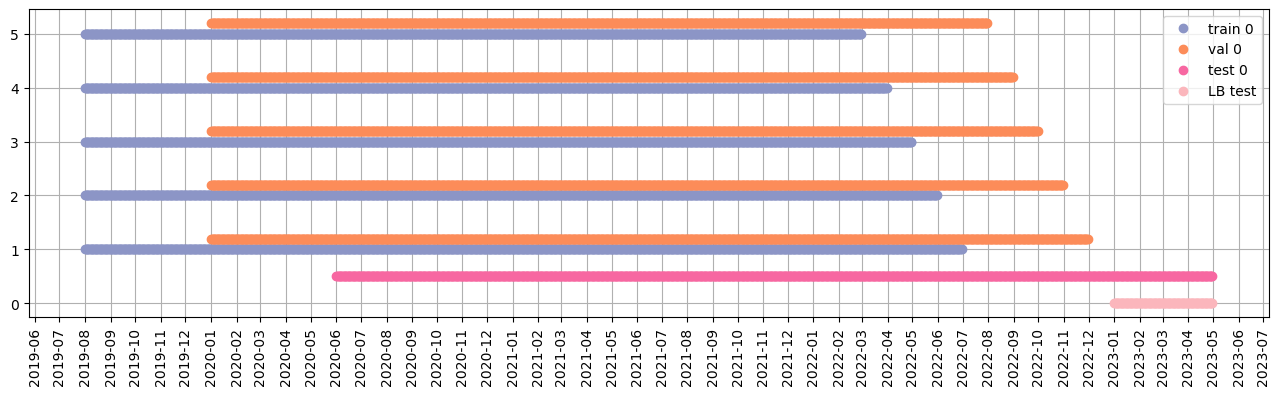

In [68]:
# Save splits

plt.figure(figsize=(16,4))
delta = datetime.timedelta(days = 1)
for split in range(num_splits):
    val_from_d = val_from[split]
    val_to_d = val_to[split]
    val_split_df = train_df.loc[(train_df.first_day_of_month >= val_from_d) & (train_df.first_day_of_month <= val_to_d)].copy()
    val_split_df.to_parquet(file_paths_save[f'val_split_{split}'])

    train_from_d = train_from[split]
    train_to_d = train_to[split]
    train_split_df = train_df.loc[(train_df.first_day_of_month >= train_from_d) & (train_df.first_day_of_month <= train_to_d)].copy()
    train_split_df.to_parquet(file_paths_save[f'train_split_{split}'])

    print('Train:', train_from_d, '-', train_to_d, end=' ')
    print('Val:', val_from_d, '-', val_to_d, end=' ')

    dates_train = drange(train_split_df.first_day_of_month.min(), train_split_df.first_day_of_month.max(), delta)
    y_train = np.ones(len(dates_train)) * 1.0 + split

    dates_val = drange(val_split_df.first_day_of_month.min(), val_split_df.first_day_of_month.max(), delta)
    y_val = np.ones(len(dates_val)) * 1.2 + split



    plt.plot_date(dates_train, y_train, color=plt.cm.BuPu(0.5), label=f'train {split}' if split==0 else '')
    plt.plot_date(dates_val, y_val, color=plt.cm.OrRd(0.5), label=f'val {split}' if split==0 else '')


split = 0
test_from_d = test_from[split]
test_to_d = test_to[split]
test_split_df = train_df.loc[(train_df.first_day_of_month >= test_from_d) & (train_df.first_day_of_month <= test_to_d)].copy()

test_target_from_d = test_target_from[split]
test_target_to_d = test_target_to[split]
tmp = test_df.copy()
tmp = tmp.loc[(tmp.first_day_of_month >= test_target_from_d) & (tmp.first_day_of_month <= test_target_to_d)].copy()
tmp['microbusiness_density'] = -1
tmp['active'] = -1
tmp['county'] = ''
tmp['state'] = ''

test_split_df = pd.concat([test_split_df, tmp], axis=0)

dates_test = drange(test_split_df.first_day_of_month.min(), test_split_df.first_day_of_month.max(), delta)
y_test = np.ones(len(dates_test)) * 0.5

plt.plot_date(dates_test, y_test, color=plt.cm.RdPu(0.5), label=f'test {split}')

test_split_df.to_parquet(file_paths_save[f'test_split_{split}'])


dates_LB = drange(datetime.date(2023,1,1), datetime.date(2023,5,1), delta)
y_LB = np.zeros(len(dates_LB))
plt.plot_date(dates_LB, y_LB, color=plt.cm.RdPu(0.3), label='LB test')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.grid()
plt.xticks(rotation=90)
plt.legend()
# plt.legend(['train', 'val', 'test', 'LB test'])
plt.show()

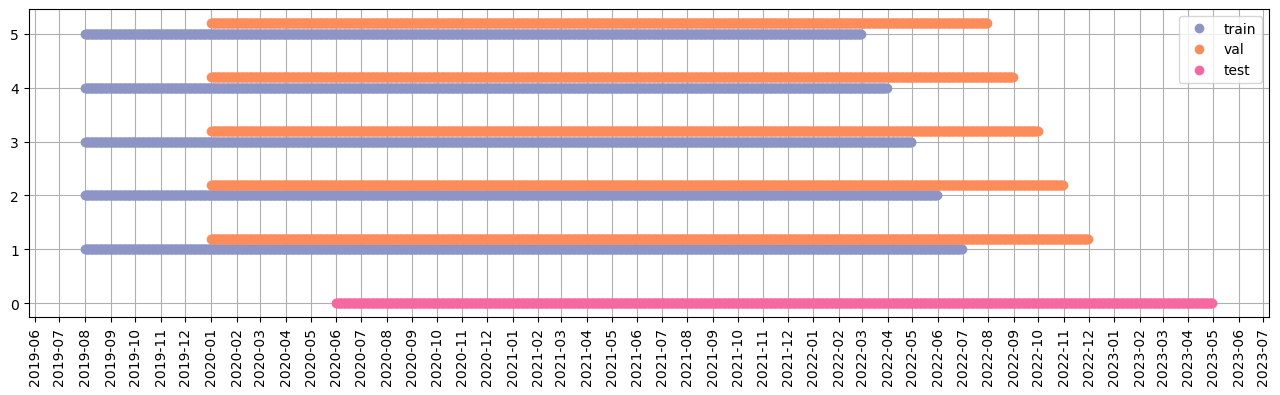

In [69]:
plt.figure(figsize=(16,4))
for split in range(cfg.num_month_splits):

    train_split_df = pd.read_parquet(file_paths_save[f'train_split_{split}'])
    val_split_df = pd.read_parquet(file_paths_save[f'val_split_{split}'])

    delta = datetime.timedelta(days = 1)
    dates = drange(train_split_df.first_day_of_month.min(), train_split_df.first_day_of_month.max(), delta)
    plt.plot_date(dates, np.ones(len(dates)) + split, color=plt.cm.BuPu(0.5), label='train' if split==0 else '')
    dates = drange(val_split_df.first_day_of_month.min(), val_split_df.first_day_of_month.max(), delta)
    plt.plot_date(dates, np.ones(len(dates))*1.2 + split, color=plt.cm.OrRd(0.5), label='val' if split==0 else '')

split = 0
test_split_df = pd.read_parquet(file_paths_save[f'test_split_{split}'])
delta = datetime.timedelta(days = 1)
dates = drange(test_split_df.first_day_of_month.min(), test_split_df.first_day_of_month.max(), delta)
plt.plot_date(dates, np.zeros(len(dates)), color=plt.cm.RdPu(0.5), label='test')


plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.grid()
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [70]:
val_split_df.dtypes

row_id                    string
cfips                      int32
county                    string
state                     string
first_day_of_month        object
microbusiness_density    float64
active                     int32
dtype: object

In [71]:
test_split_df.dtypes

row_id                    string
cfips                      int32
county                    object
state                     object
first_day_of_month        object
microbusiness_density    float64
active                     int64
dtype: object

In [72]:
test_split_df.isna().any()

row_id                   False
cfips                    False
county                   False
state                    False
first_day_of_month       False
microbusiness_density    False
active                   False
dtype: bool